# VQC Partitioning

Many circuit types have somewhat trivial structures to partition, making complex partitioning methods inefficient and unnecessary. In such cases we may look to deterministic methods for the partitioning. Variational quantum circuits (VQCs) for example, typically contain uniform entangling structures which require minimal shared entanglement. As a case study, we look at variational quantum circuits used in *quantum support vector machine circuits (QSVM)*.


## Transpilation

We begin by defining a circuit and using the built in qiskit transpiler to put it into the (u,cp) gate-set.

In [15]:
import qiskit.qasm3
from disqco.graphs.quantum_network import QuantumNetwork
import numpy as np
import qiskit
from qiskit import transpile, QuantumCircuit
import math as mt

num_qubits = 8

circuit = QuantumCircuit(num_qubits)

input_string = np.random.randint(0, 2, 2**num_qubits)
# Normalise by by square of number of non-zero elements
input_string = input_string / mt.sqrt(np.sum(input_string))

circuit.initialize(input_string)

ansatz = qiskit.qasm3.load(f'qasm/circuit_008.qasm')

param_values = np.random.rand(len(ansatz.parameters))
param_dict = dict(zip(ansatz.parameters, param_values))
v_circuit = ansatz.assign_parameters(param_dict) 

# v_circ = v_circuit.to_instruction()

circuit.compose(v_circuit, inplace=True)

num_qubits = int(v_circuit.num_qubits)

num_partitions = 2 # Define the number of partitions or QPUs you will distribute over
depth = v_circuit.depth()

qpu_size = num_qubits // num_partitions  # Define the number of qubits per QPU. For simplicity, we divide qubits evenly and add one additional space to each for teleportation (an extra space is needed for the teleportation qubit so the algorithmr requires it!)
qpu_sizes = [qpu_size] * num_partitions # Store the number of qubits per QPU in a list

# Create a quantum network with the specified number of qubits and partitions
# If we do not specificy the connectivity, we have all-to-all by default.

quantum_network = QuantumNetwork(qpu_sizes)

basis_gates = ['u', 'cp']

# Transpile the circuit to the basis gates
circuit = transpile(circuit, basis_gates=basis_gates)

print(f'Number of qubits in circuit {v_circuit.num_qubits}')
print(f'Circuit depth: {circuit.depth()}')



Number of qubits in circuit 8
Circuit depth: 524


# Graph conversion

We first convert the circuit to a graph, to calculate the entanglement requirements.

In [16]:
from disqco.graphs.QC_hypergraph import QuantumCircuitHyperGraph
from disqco.parti.FM.FM_methods import set_initial_partition_assignment

depth = circuit.depth() # Get the depth of the circuit

graph = QuantumCircuitHyperGraph(circuit, group_gates=False, anti_diag=True, map_circuit=True) # First analyse without using gate grouping.
assignment = set_initial_partition_assignment(graph, quantum_network)


The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz


<Axes: >

Number of ebits required: 62


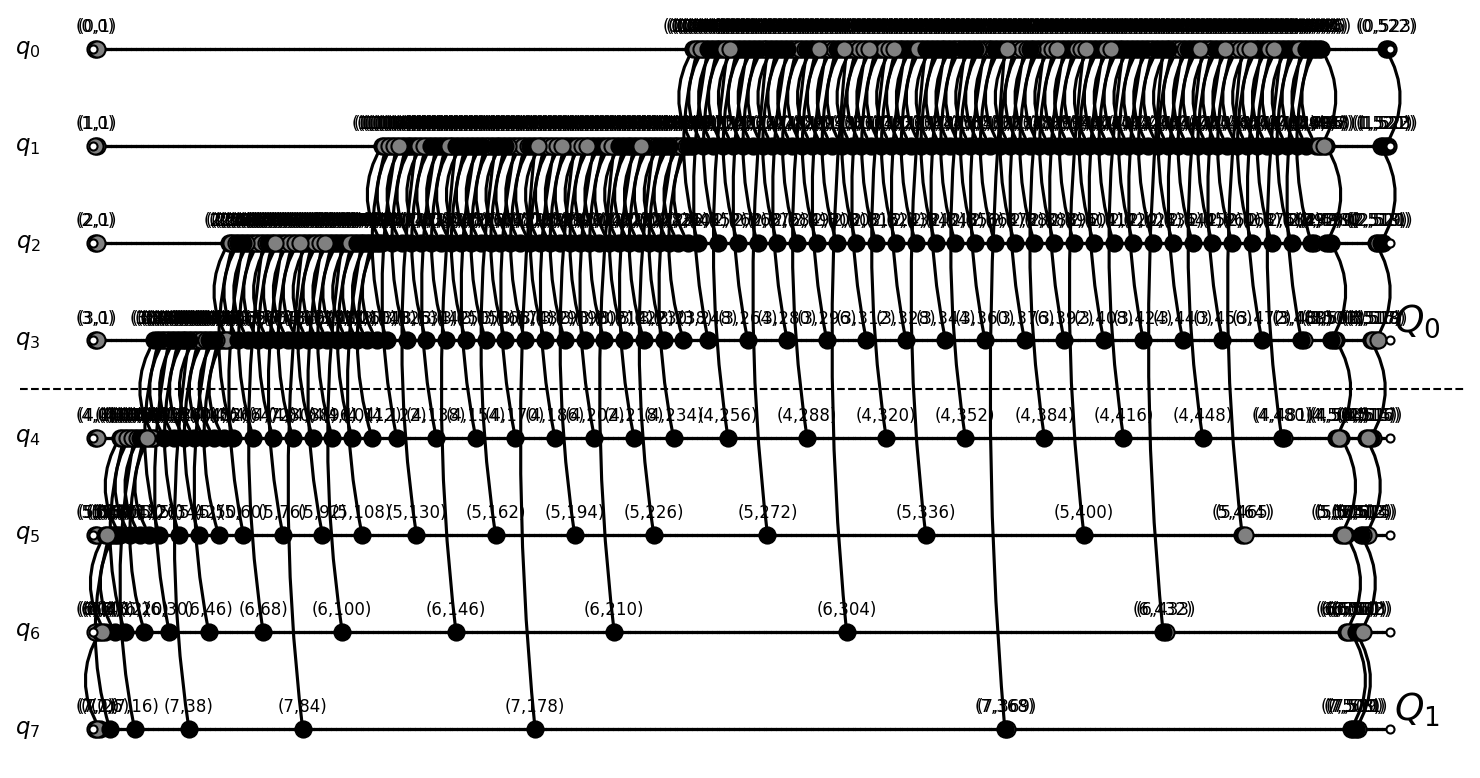

In [17]:
from disqco.parti.FM.FM_methods import calculate_full_cost

%load_ext jupyter_tikz


fig = graph.draw(quantum_network, assignment, qpu_sizes, show_labels=True, output='mpl')
display(fig)

ebit_cost = calculate_full_cost(graph, assignment, num_partitions)

print(f'Number of ebits required: {ebit_cost}')

It can be clearly seen from the figure that we will not gain any benefit by trying to optimise the partitioning further, since we will always have two non-local gates.

However, we can half the number of required EPR pairs using gate grouping.

In [18]:
graph_grouped = QuantumCircuitHyperGraph(circuit, group_gates=True, anti_diag=True, map_circuit=True) # Now use gate grouping to merged edges into hyper-edges for gate teleportation.

<Axes: >

Number of ebits required after gate grouping: 5


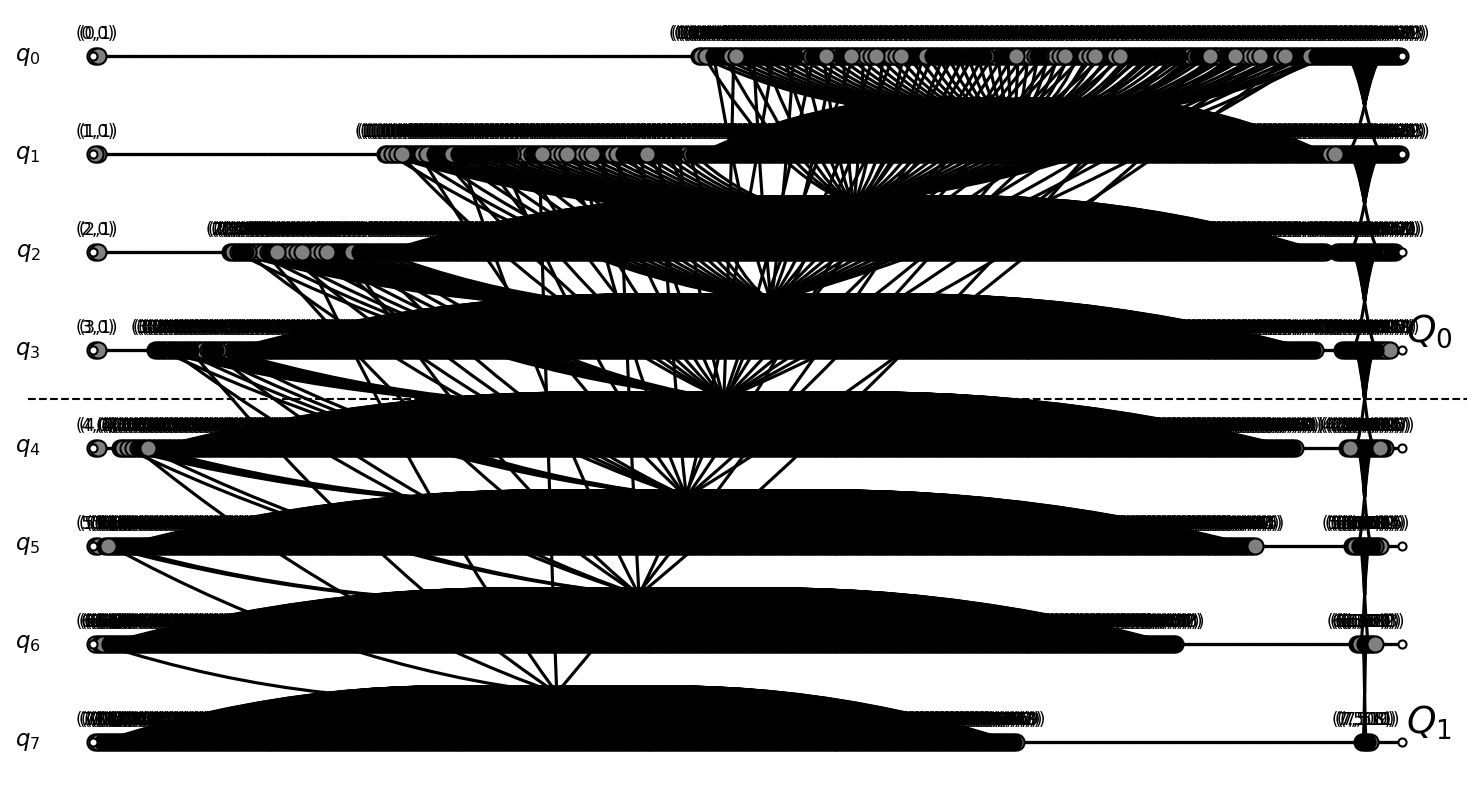

In [19]:
fig = graph_grouped.draw(quantum_network, assignment, qpu_sizes, show_labels=True, output='mpl')
display(fig)

ebit_cost = calculate_full_cost(graph_grouped, assignment, num_partitions)
print(f'Number of ebits required after gate grouping: {ebit_cost}')


We can clearly see that we only have one hyper-edge cutting the partition boundary, which indicates we can use one EPR pair to cover the two corresponding gates.

# Circuit extraction



In [20]:
from disqco.circuit_extraction.circuit_extractor import PartitionedCircuitExtractor
from disqco.parti.FM.FM_methods import calculate_full_cost

extractor = PartitionedCircuitExtractor(graph=graph_grouped, 
                                        partition_assignment=assignment, 
                                        network=quantum_network)

final_circuit = extractor.extract_partitioned_circuit()

ebit_cost = calculate_full_cost(graph, assignment, num_partitions)

print(f'Number of ebits required: {ebit_cost}')

Number of ebits required: 62


In [21]:
final_circuit = transpile(final_circuit, basis_gates=basis_gates + ['EPR'])

print("Number of EPR pairs in partitioned circuit: ", final_circuit.count_ops()['EPR'])

Number of EPR pairs in partitioned circuit:  5


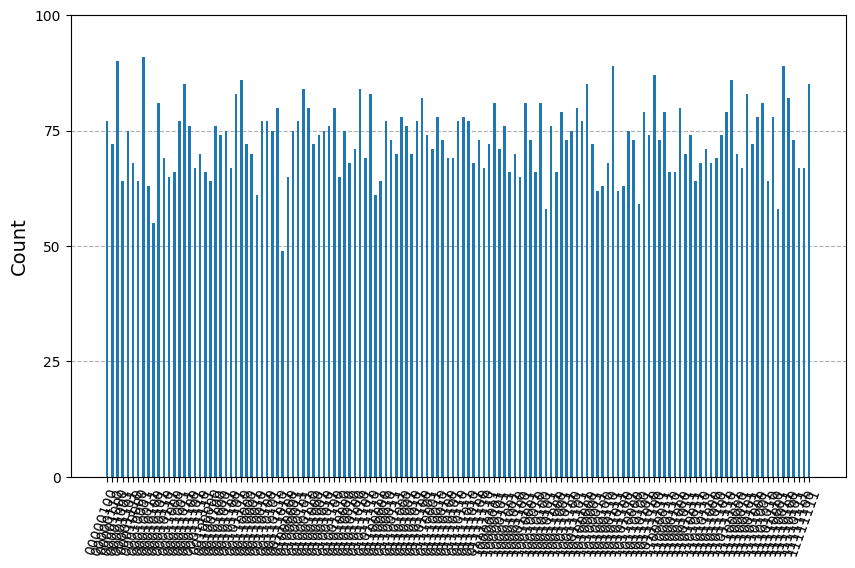

In [22]:
from disqco.circuit_extraction.verification import run_sampler, plot

measured_circuit = circuit.copy()
measured_circuit.measure_all()

data_circ = run_sampler(measured_circuit, shots=10000)

plot(data_circ, labels=True)

In [23]:
# data_qubits = [qubit for qubit in final_circuit.qubits if qubit._register.name[0] == 'Q']

# print(data_qubits)


# def initialise_partitioned_circuit(circuit, input_string):
    
#     data_qubits = [qubit for qubit in final_circuit.qubits if qubit._register.name[0] == 'Q']





# final_circuit.initialize(input_string, qubits=data_qubits)

# ata_circ_part = run_sampler(final_circuit, shots=10000)



# plot(data_circ_part, labels=True)

In [24]:
final_circuit.draw(output='mpl', style = 'bw', fold=100) # Draw the circuit

See circuit extraction notebook for more!